In [ ]:
import numpy as np
import torch
import random
import math
from collections import namedtuple
import os
import time

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.signal import medfilt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

 <h1>Создание экземпляров  </h1>
 <p>Генерация случайных графов </p>

In [ ]:
def get_graph_mat(n=10, size=1): # генерируем n узлов случайным образам
         
    coords = size * np.random.uniform(size=(n,2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat  # Возвращает матрицу координат (N, 2) и матрицу (N, N), содержащую попарные евклидовы расстояния.

def plot_graph(coords, mat): #Функция для построения полносвязного графика

    n = len(coords)
    
    plt.scatter(coords[:,0], coords[:,1], s=[50 for _ in range(n)])
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([coords[i,0], coords[j,0]], [coords[i,1], coords[j,1]], 'b', alpha=0.7)

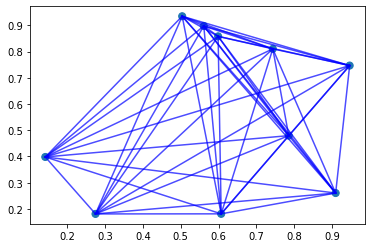

In [ ]:
coords, W_np = get_graph_mat(n=10)
plot_graph(coords, W_np)

In [ ]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))
  
def state2tens(state):
   # Создаем Pytorch tensor представляющий историю посещенных узлов одного кортежа.
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if len(state.partial_solution) > 0 else -1
    sol_first_node = state.partial_solution[0] if len(state.partial_solution) > 0 else -1
    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == sol_first_node else 0),
           (1 if i == sol_last_node else 0),
           coords[i,0],
           coords[i,1]
          ] for i in range(nr_nodes)]
    
    return torch.tensor(xv, dtype=torch.float32, requires_grad=False, device=device)

<h1>Q-функция</h1> 

In [ ]:
class QNet(nn.Module):
  #Вход - это state (содержащее граф и посещенные узлы)
  #выходе - вектор размера N, содержащий Q (s, a) 
    def __init__(self, emb_dim, T=4):
        # T - количество итераций
        super(QNet, self).__init__()
        self.emb_dim = emb_dim
        self.T = T
        
        self.node_dim = 5

        nr_extra_layers_1 = 1
        
        # learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.emb_dim, True)
        self.theta2 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta3 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta4 = nn.Linear(1, self.emb_dim, True)
        self.theta5 = nn.Linear(2*self.emb_dim, 1, True)
        self.theta6 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta7 = nn.Linear(self.emb_dim, self.emb_dim, True)
        
        self.theta1_extras = [nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)]
        
    def forward(self, xv, Ws):
        
        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]
        
        conn_matrices = torch.where(Ws > 0, torch.ones_like(Ws), torch.zeros_like(Ws)).to(device)
        
        mu = torch.zeros(batch_size, num_nodes, self.emb_dim, device=device)
        s1 = self.theta1(xv)  
        for layer in self.theta1_extras:
            s1 = layer(F.relu(s1))  
        
        s3_1 = F.relu(self.theta4(Ws.unsqueeze(3)))        
        s3_2 = torch.sum(s3_1, dim=1)  
        s3 = self.theta3(s3_2) 
        
        for t in range(self.T):
            s2 = self.theta2(conn_matrices.matmul(mu))    
            mu = F.relu(s1 + s2 + s3)
            
        global_state = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, num_nodes, 1))
        
        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)
            
        out = F.relu(torch.cat([global_state, local_action], dim=2))
        return self.theta5(out).squeeze(dim=2)

In [ ]:
model = QNet(3, T=1).to(device)
coords, W_np = get_graph_mat(n=10)
W = torch.tensor(W_np, dtype=torch.float32, device=device)
xv = torch.rand((1, W.shape[0], 5)).to(device) # random node state
Ws = W.unsqueeze(0)

y = model(xv, Ws)
print('model output: {}'.format(y))

model output: tensor([[2.3491, 2.3491, 2.3491, 2.3491, 2.3491, 2.3491, 2.3491, 2.3491, 2.3491,
         2.3491]], grad_fn=<SqueezeBackward1>)


In [ ]:

class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.MSELoss()
    
    def predict(self, state_tsr, W):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr.unsqueeze(0), W.unsqueeze(0))
        return estimated_rewards[0]
                
    def get_best_action(self, state_tsr, state):

        W = state.W
        estimated_rewards = self.predict(state_tsr, W)  # size (nr_nodes,)
        sorted_reward_idx = estimated_rewards.argsort(descending=True)
        
        solution = state.partial_solution
        
        already_in = set(solution)
        for idx in sorted_reward_idx.tolist():
            if (len(solution) == 0 or W[solution[-1], idx] > 0) and idx not in already_in:
                return idx, estimated_rewards[idx].item()
        
    def batch_update(self, states_tsrs, Ws, actions, targets):
   
        Ws_tsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        self.optimizer.zero_grad()
        
        # the rewards estimated by Q for the given actions
        estimated_rewards = self.model(xv, Ws_tsr)[range(len(actions)), actions]
        
        loss = self.loss_fn(estimated_rewards, torch.tensor(targets, device=device))
        loss_val = loss.item()
        
        loss.backward()
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return loss_val

In [ ]:
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)

In [ ]:
def total_distance(solution, W):
    if len(solution) < 2:
        return 0  # there is no travel
    
    total_dist = 0
    for i in range(len(solution) - 1):
        total_dist += W[solution[i], solution[i+1]].item()
        
    # if this solution is "complete", go back to initial point
    if len(solution) == W.shape[0]:
        total_dist += W[solution[-1], solution[0]].item()

    return total_dist
        
def is_state_final(state):
    return len(set(state.partial_solution)) == state.W.shape[0]

def get_next_neighbor_random(state):
    solution, W = state.partial_solution, state.W
    
    if len(solution) == 0:
        return random.choice(range(W.shape[0]))
    already_in = set(solution)
    candidates = list(filter(lambda n: n.item() not in already_in, W[solution[-1]].nonzero()))
    if len(candidates) == 0:
        return None
    return random.choice(candidates).item()

In [ ]:
SEED = 1  

# Graph
NR_NODES = 10  
EMBEDDING_DIMENSIONS = 5  
EMBEDDING_ITERATIONS_T = 1  

# Learning
NR_EPISODES = 4001
MEMORY_CAPACITY = 10000
N_STEP_QL = 2  
BATCH_SIZE = 16

GAMMA = 0.9
INIT_LR = 5e-3
LR_DECAY_RATE = 1. - 2e-5 

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 6e-4 

FOLDER_NAME = './models' 

In [ ]:
def init_model(fname=None):
    Q_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)
    
    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    Q_func = QFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler

def checkpoint_model(model, optimizer, lr_scheduler, loss, 
                     episode, avg_length):
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)
    
    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.tar'
    
    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)

In [ ]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Q_func, Q_net, optimizer, lr_scheduler = init_model()


memory = Memory(MEMORY_CAPACITY)


found_solutions = dict()  
losses = []
path_lengths = []


current_min_med_length = float('inf')

for episode in range(NR_EPISODES):
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    

    solution = [random.randint(0, NR_NODES-1)]
    
 
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)
    
   
    states = [current_state]
    states_tsrs = [current_state_tsr]  
    rewards = []
    actions = []
    

    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)
    
    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  
        
        if epsilon >= random.random():

            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
     
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))
        
        next_solution = solution + [next_node]
        

        reward = -(total_distance(next_solution, W) - total_distance(solution, W))
        
        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)
        
    
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)
        

        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))
            
        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n], 
                                           action=actions[-n], 
                                           reward=sum(rewards[-n:]), 
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))
        
   
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution
        

        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)
            
            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []
            
            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr, 
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)
                
  
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)
            

            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)
                
    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

Ep 0. Loss = -1.000 / median length = 3.487 / last = 3.4873 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 5.717 / last = 5.7169 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 4.974 / last = 4.3185 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 4.974 / last = 3.7427 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 4.974 / last = 5.0773 / epsilon = 0.9763 / lr = 0.0050
Ep 50 | current sol: [8, 5] / next est reward: 0.037708528339862823
Ep 50 | current sol: [8, 5, 7, 4] / next est reward: 0.10300328582525253
Ep 50. Loss = -1.000 / median length = 5.000 / last = 5.7980 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 5.036 / last = 6.1192 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 5.194 / last = 5.5106 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 5.270 / last = 6.1859 / epsilon = 0.9531 / lr = 0.0050
Ep 90. Loss = 

Text(0.5, 0, 'episode')

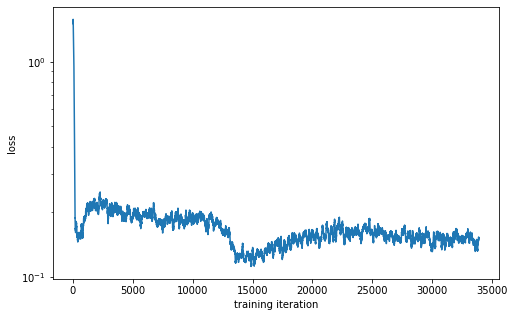

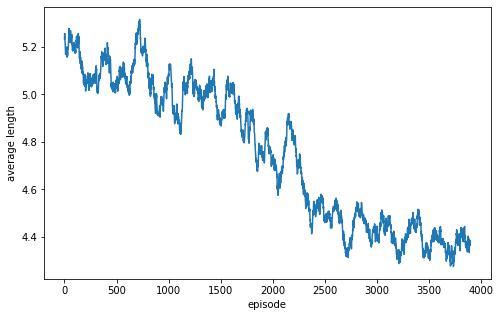

In [ ]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(losses, 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(_moving_avg(path_lengths, 100))
plt.ylabel('average length')
plt.xlabel('episode')

shortest avg length found: 4.166822470724583


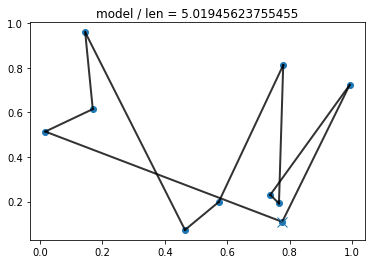

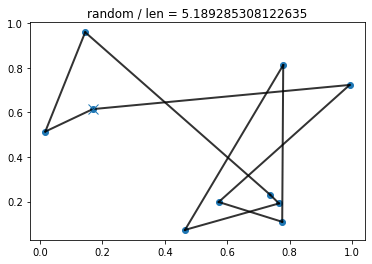

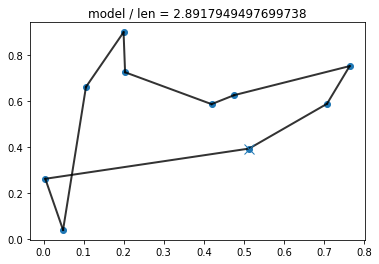

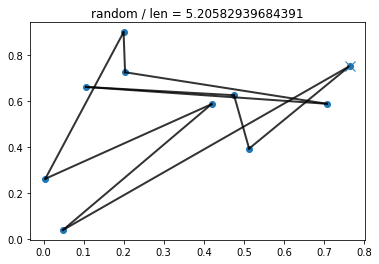

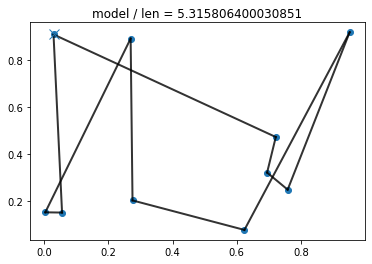

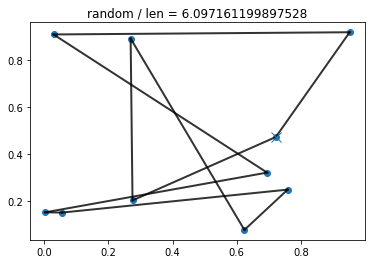

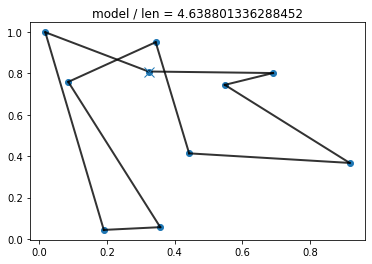

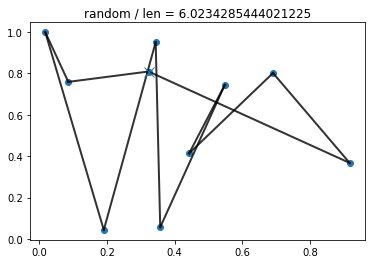

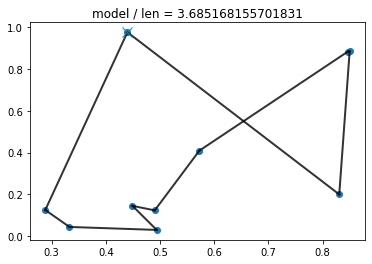

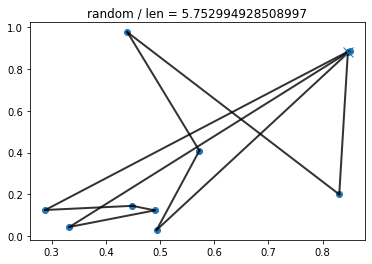

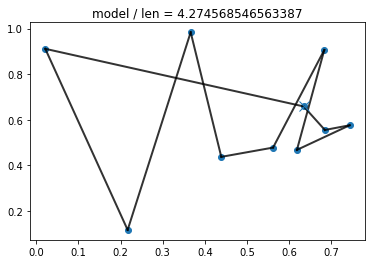

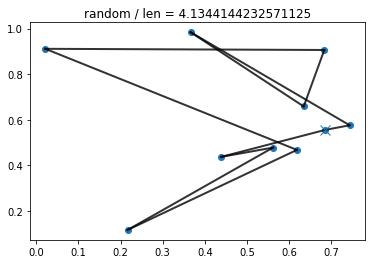

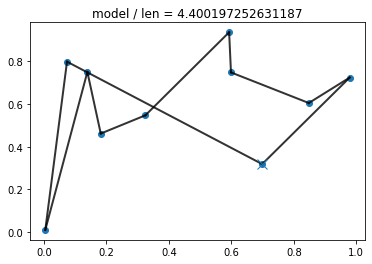

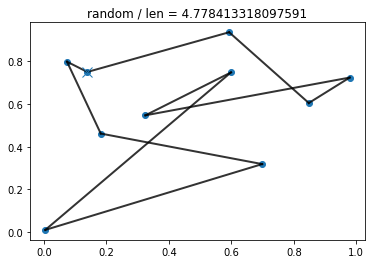

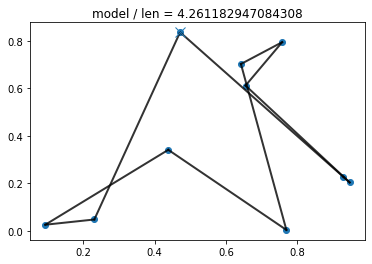

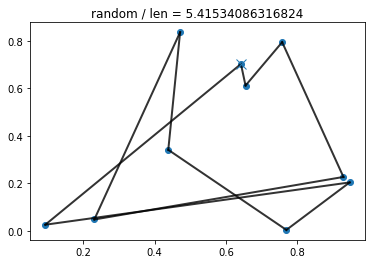

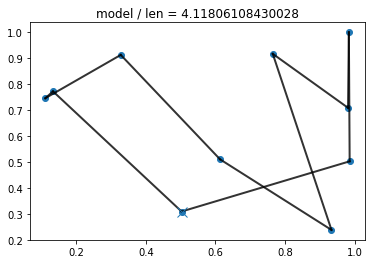

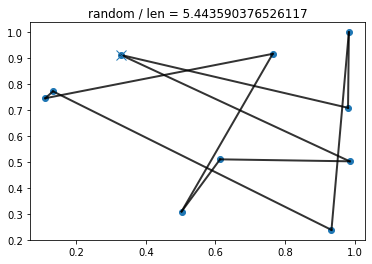

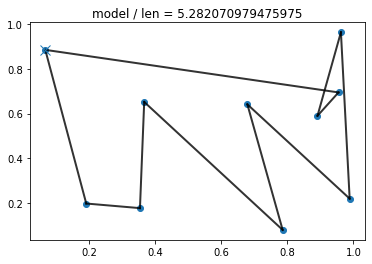

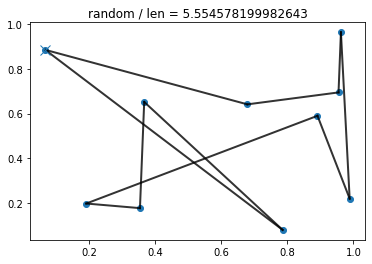

In [ ]:


all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))


Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))


def plot_solution(coords, mat, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)
    
    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    
    i, next_i = solution[-1], solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10)


    

NR_NODES = 10
for sample in range(10):
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
    solution = [random.randint(0, NR_NODES-1)]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)
    
    while not is_state_final(current_state):
        next_node, est_reward = Q_func.get_best_action(current_state_tsr, 
                                                       current_state)
        
        
        solution = solution + [next_node]
        current_state = State(partial_solution=solution, W=W, coords=coords)
        current_state_tsr = state2tens(current_state)
        
    plt.figure()
    plot_solution(coords, W, solution)
    plt.title('model / len = {}'.format(total_distance(solution, W)))
    
    # for comparison, plot a random solution
    plt.figure()
    random_solution = list(range(NR_NODES))
    plot_solution(coords, W, random_solution)
    plt.title('random / len = {}'.format(total_distance(random_solution, W)))